# Forest Cover Type Prediction

In [2]:
from xgboost import XGBClassifier
from sklearn.svm import SVC

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

## Data Set Information:

* Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types). 

* This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. 

* Some background information for these four wilderness areas: 
  * Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas.
  * Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value. 

* As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4). 

* The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

# Features
* Elevation - Elevation in meters, 해발 고도
* Aspect - Aspect in degrees azimuth, 자침(나침반) 각도 [0-360]
* Slope - Slope in degrees, 경사 각도 [0-360]
<br><br>
* Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
* Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
<br><br>
* Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
* Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
<br><br>
* Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
* Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
* Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
<br><br>
* Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
* Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
<br><br>
* Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

## 

In [4]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
train_df.tail()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
15115,15116,2607,243,23,258,7,660,170,251,214,...,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,...,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,...,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,...,0,0,0,0,0,0,0,0,0,3
15119,15120,2475,197,34,319,78,270,189,244,164,...,0,0,0,0,0,0,0,0,0,3


In [6]:
test_df.tail()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
565887,581008,2396,153,20,85,17,108,240,237,118,...,0,0,0,0,0,0,0,0,0,0
565888,581009,2391,152,19,67,12,95,240,237,119,...,0,0,0,0,0,0,0,0,0,0
565889,581010,2386,159,17,60,7,90,236,241,130,...,0,0,0,0,0,0,0,0,0,0
565890,581011,2384,170,15,60,5,90,230,245,143,...,0,0,0,0,0,0,0,0,0,0
565891,581012,2383,165,13,60,4,67,231,244,141,...,0,0,0,0,0,0,0,0,0,0


# Feature categorization
[Continuous]
* 'Elevation'
* 'Horizontal_Distance_To_Hydrology'
* 'Vertical_Distance_To_Hydrology'
* 'Horizontal_Distance_To_Roadways'
* 'Horizontal_Distance_To_Fire_Points'

<br>
[Categorical]
* 'Aspect', 'Slope'
  * [0-360] index
* 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'
  * [0-255] index
* Wilderness_{1-4}
  * 1 - Rawah Wilderness Area
  * 2 - Neota Wilderness Area
  * 3 - Comanche Peak Wilderness Area
  * 4 - Cache la Poudre Wilderness Area
* Soil_Type{1-40}

<br>
[Target feature]
* 'Cover_Type'
  * 1 - Spruce/Fir
  * 2 - Lodgepole Pine
  * 3 - Ponderosa Pine
  * 4 - Cottonwood/Willow
  * 5 - Aspen
  * 6 - Douglas-fir
  * 7 - Krummholz

In [7]:
major_features = ['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',\
                         'Horizontal_Distance_To_Fire_Points', 'Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

In [8]:
f, atrain_dfarr = plt.subplots(2, 5)

for i, col in enumerate(major_features):
    
    if i < 5:
        atrain_dfarr[0, i].hist(train_df[col])
        atrain_dfarr[0, i].set_title(col)
        
    else:
        atrain_dfarr[1, i-5].hist(train_df[col])
        atrain_dfarr[1, i-5].set_title(col)

# Fine-tune figure; hide train_df ticks for top plots and y ticks for right plots
#plt.setp([a.get_train_dfticklabels() for a in atrain_dfarr[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in atrain_dfarr[:, 1]], visible=False)
#plt.figure(figsize=(100,100))
plt.subplots_adjust(left=0.1, right=2.0, top=0.9, bottom=0.1)
plt.show()

NameError: name 'X' is not defined

## Overall characteristics of forests(labels) using groupby


* Some background information for these four wilderness areas: 

  * Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value. 
  * As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4). 
  * The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.



In [72]:
# Wilderness_Area areas - elevation

for wilderness in ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']:
    print(wilderness, '- mean elevation:', train_df.groupby(wilderness)['Elevation'].mean()[1])

Wilderness_Area1 - mean elevation: 2996.32527106
Wilderness_Area2 - mean elevation: 3341.04408818
Wilderness_Area3 - mean elevation: 2923.11608127
Wilderness_Area4 - mean elevation: 2260.09197861


CoverType1 - mean elevation: 3128.025925925926 / std: 156.12498785692443


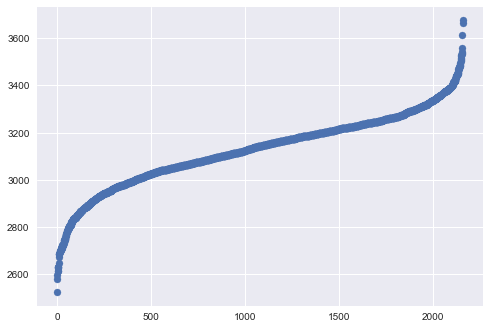

CoverType2 - mean elevation: 2922.5402777777776 / std: 185.77826795108646


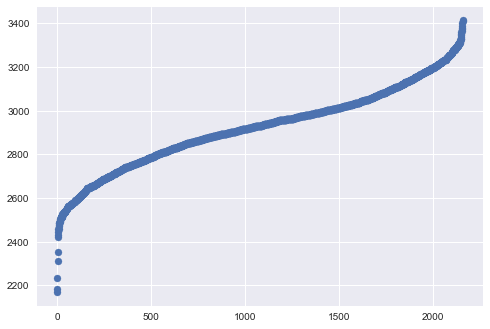

CoverType3 - mean elevation: 2398.4231481481484 / std: 194.10814713683976


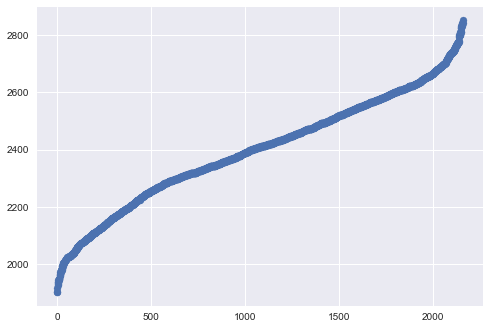

CoverType4 - mean elevation: 2223.42037037037 / std: 102.9299403863196


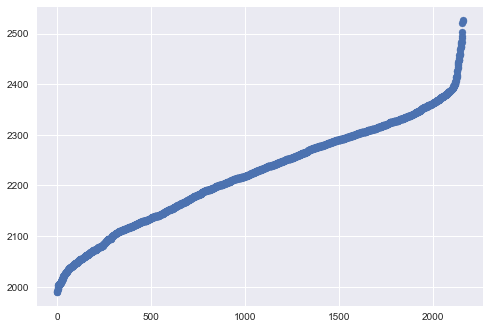

CoverType5 - mean elevation: 2786.801388888889 / std: 96.17746882654535


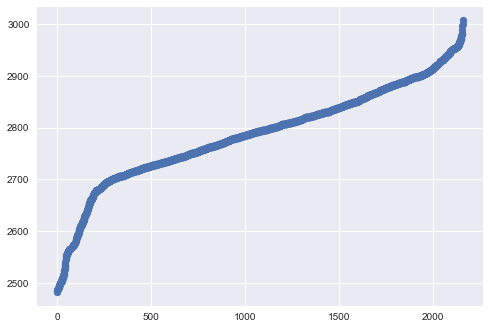

In [88]:
for covertype in range(1,6):
    print('CoverType'+str(covertype)+\
          ' - mean elevation:', train_df[train_df.Cover_Type==covertype]['Elevation'].mean(),\
          '/ std:', train_df[train_df.Cover_Type==covertype]['Elevation'].std())
    
    plt.scatter(range(len(train_df[train_df.Cover_Type==covertype]['Elevation'])), train_df[train_df.Cover_Type==covertype]['Elevation'].sort_values())
    plt.show()

### Elevation -> 5개의 유의미한 범위를 기준으로 5개의 카테고리컬 변수로 변환 가능할 것으로 보임.

In [137]:
# 긱 CoverType에 대한 Elevation값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Elevation'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Elevation'].sort_values().iloc[-1])

2525 3675
2169 3413
1903 2850
1989 2526
2482 3007
1863 2883
2870 3849


In [31]:
train_df.groupby('Cover_Type')['Elevation']

Cover_Type
1    3128.325926
2    2922.840278
3    2398.723148
4    2223.720370
5    2787.101389
6    2423.576852
7    3363.069907
Name: Elevation, dtype: float64

In [112]:
# 긱 CoverType에 대한 Aspect값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Aspect'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Aspect'].sort_values().iloc[-1])

0 359
0 359
0 360
0 359
0 359
0 360
0 359


In [113]:
# 긱 CoverType에 대한 Slope값의 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Slope'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Slope'].sort_values().iloc[-1])

1 41
0 45
1 47
1 46
1 50
1 52
0 49


In [167]:
# 긱 CoverType에 대한 Hillshade Index 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].sort_values().iloc[-1], \
         train_df[train_df.Cover_Type==covertype]['Hillshade_9am'].mean())

86 254 211.69027777777777
83 254 214.04444444444445
58 254 201.65555555555557
127 254 227.96805555555557
130 254 223.36898148148148
0 254 193.56296296296296
97 254 216.63981481481483


In [168]:
# 긱 CoverType에 대한 Hillshade Index 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Hillshade_Noon'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Hillshade_Noon'].sort_values().iloc[-1], \
         train_df[train_df.Cover_Type==covertype]['Hillshade_Noon'].mean())

125 254 223.2486111111111
115 254 225.3699074074074
120 254 216.5611111111111
137 254 216.88981481481483
99 254 218.31712962962962
127 254 209.96064814814815
99 254 222.41203703703704


In [169]:
# 긱 CoverType에 대한 Hillshade Index 최소/최대값
for covertype in range(1, 8):
    print(train_df[train_df.Cover_Type==covertype]['Hillshade_3pm'].sort_values().iloc[0], \
          train_df[train_df.Cover_Type==covertype]['Hillshade_3pm'].sort_values().iloc[-1], \
         train_df[train_df.Cover_Type==covertype]['Hillshade_3pm'].mean())

0 246 144.06574074074075
6 248 142.95092592592593
0 248 141.54953703703703
0 230 111.8087962962963
0 229 121.39259259259259
22 238 147.6824074074074
0 226 136.19398148148147


In [14]:
soils_covers = []

for cover in range(1, 8):
    soils_cover = []
    for soil_num in range(1, 41):
        
        soiltype_by_covertype = train_df[train_df.Cover_Type==cover]['Soil_Type'+str(soil_num)].sum()
        #print('Soil_Type'+str(soil_num), soiltype_by_covertype)
        soils_cover.append(soiltype_by_covertype)
    soils_covers.append(soils_cover)

In [15]:
soils_by_covertypes = []

for i, cover in enumerate(soils_covers):
    print(cover)
    
    soils_by_covertype = []
    for i, soilcover in enumerate(cover):
        if soilcover:
            soils_by_covertype.append(i+1)
            
    soils_by_covertypes.append(soils_by_covertype)

[0, 0, 0, 5, 0, 0, 0, 0, 1, 9, 5, 24, 17, 0, 0, 9, 2, 0, 15, 41, 12, 275, 376, 128, 0, 7, 7, 0, 407, 81, 114, 230, 184, 0, 3, 0, 0, 80, 79, 49]
[0, 3, 12, 20, 0, 7, 0, 1, 9, 81, 67, 203, 84, 0, 0, 14, 7, 16, 13, 55, 0, 54, 149, 72, 1, 19, 5, 6, 554, 144, 97, 255, 184, 12, 1, 2, 0, 7, 3, 3]
[121, 283, 133, 462, 55, 248, 0, 0, 0, 717, 89, 0, 4, 4, 0, 5, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]
[139, 94, 799, 133, 39, 244, 0, 0, 0, 170, 24, 0, 0, 128, 0, 40, 350, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 61, 0, 129, 0, 0, 0, 0, 0, 64, 154, 0, 305, 0, 0, 9, 131, 44, 18, 6, 0, 0, 157, 11, 0, 28, 0, 3, 254, 480, 87, 100, 115, 4, 0, 0, 0, 0, 0, 0]
[95, 182, 18, 87, 71, 151, 0, 0, 0, 1101, 67, 0, 66, 37, 0, 37, 88, 0, 0, 37, 0, 0, 3, 15, 0, 0, 0, 0, 0, 0, 7, 30, 66, 2, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 16, 72, 31, 0, 0, 3, 0, 76, 20, 27, 70, 67, 4, 98, 8, 34, 641, 575, 407]


CoverType|SoilTypes|len(SoilTypes)
:---:|:---:|:---:
1|4, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 35, 38, 39, 40|25
2|2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40|33
3|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 32|13
4|1, 2, 3, 4, 5, 6, 10, 11, 14, 16, 17|11
5|2, 4, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34|20
6|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 20, 23, 24, 31, 32, 33, 34|19
7|4, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40|18

In [19]:
sns.set_style("white")

In [17]:
def create_zero_column(length, name):
    return pd.DataFrame(np.zeros(length), columns=[name], dtype=int)

In [18]:
def create_dist_prob_columns_(Xdf, ydf, target, log=False):
    
    if log:
        Xdf[target+'_log'] = np.log(Xdf[target])
        #X_test[target+'_log'] = np.log(X_test[target])
    
    for i in ydf.unique():
        elev_cover_idx = (ydf==i)

        elev_cover_mean = Xdf[target+'_log'][elev_cover_idx].mean()
        elev_cover_std = Xdf[target+'_log'][elev_cover_idx].std()
        
        #Xdf[target+'_log_pdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        #Xdf[target+'_log_cdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        
        Xdf[target+'_log_pdf_'+str(i)] = norm.pdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        Xdf[target+'_log_cdf_'+str(i)] = norm.cdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        #X_test[target+'_log_pdf_'+str(i)] = norm.pdf(X_test[target+'_log'],elev_cover_mean, elev_cover_std)
        #X_test[target+'_log_cdf_'+str(i)] = norm.cdf(X_test[target+'_log'],elev_cover_mean, elev_cover_std)
        
        for j in Xdf['Wilderness_Area'].unique():
            
            elev_wild_cover_idx = ((ydf==i) & (X_test['Wilderness_Area']==j))

            elev_wild_cover_mean = Xdf[target+'_log'][elev_wild_cover_idx].mean()
            elev_wild_cover_std = Xdf[target+'_log'][elev_wild_cover_idx].std()
            
            #Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            #Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            
            Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            #X_test[target+'_log_wild_pdf_'+str(i)+str(j)] = \
            #                                norm.pdf(X_test[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            #X_test[target+'_log_wild_cdf_'+str(i)+str(j)] = \
            #                                norm.cdf(X_test[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            
            
    Xdf.fillna(0, inplace=True)
    #X_test.fillna(0, inplace=True)


# Two categorical criteria for conditional distribution graph

### Cover_Type (Target Feature, 7 classes)

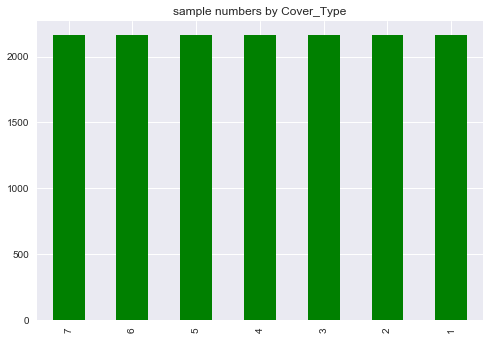

In [13]:
train_df.Cover_Type.value_counts().plot(kind='bar', color='g'); plt.title('sample numbers by Cover_Type'); plt.show()

### Wilderness_Area (4 classes)

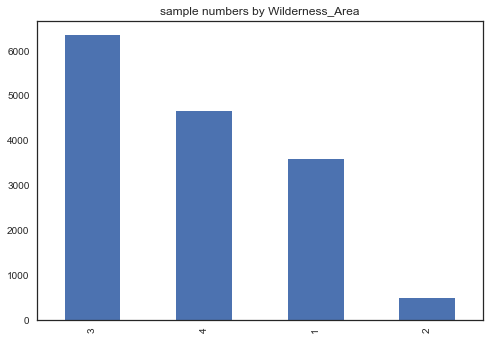

In [460]:
train_df.Wilderness_Area.value_counts().plot(kind='bar'); plt.title('sample numbers by Wilderness_Area'); plt.show()

In [20]:
con_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

for cont in con_cols:
    
    #print(cont, len(train_df[cont][train_df[cont]==0]))
    #print(cont, len(test_df[cont][test_df[cont]==0]))
    
    #print(' - ')
    
    test_df[cont] += 0.3
    train_df[cont] += 0.3
    #print(cont, len(train_df[cont][train_df[cont]==0]))
    #print(cont, len(test_df[cont][test_df[cont]==0]))
    #print(' # ')

In [21]:
train_df['Wilderness_Area'] = create_zero_column(train_df.shape[0], 'Wilderness_Area')
for i in range(1, 5):
    wilderness = 'Wilderness_Area'+str(i)
    train_df['Wilderness_Area'][train_df[wilderness]==1] += i

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Conditional distribution graph
* 로그 변환으로 정규분포에 가깝게 변환한 뒤, 로그값 분포의 차이가 유의미한 경우
  * create_dist_prob_columns 함수를 이용하여 해당 feature의 로그값이 각 로그 분포에 속할 확률을 feature로 생성한다.

## Slope

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


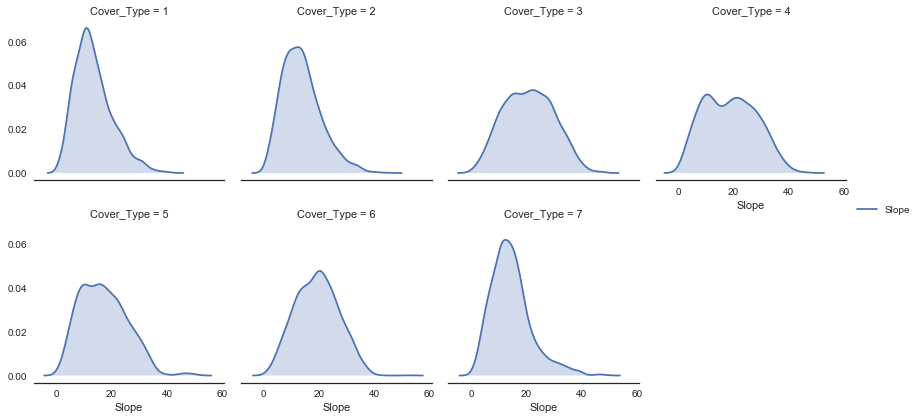

In [44]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


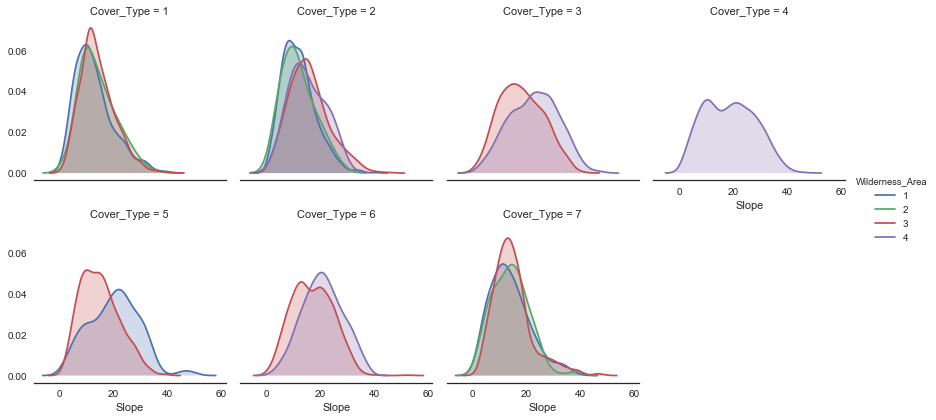

In [22]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Slope", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [23]:
train_df['Slope_log'] = np.log(train_df['Slope'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


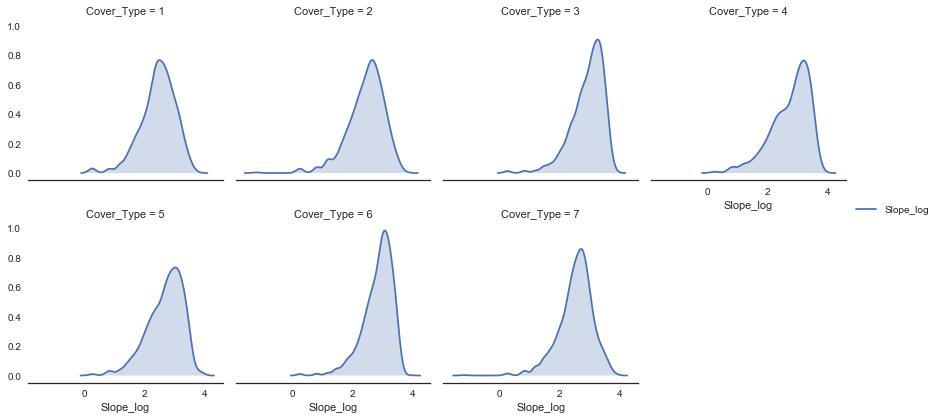

In [24]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


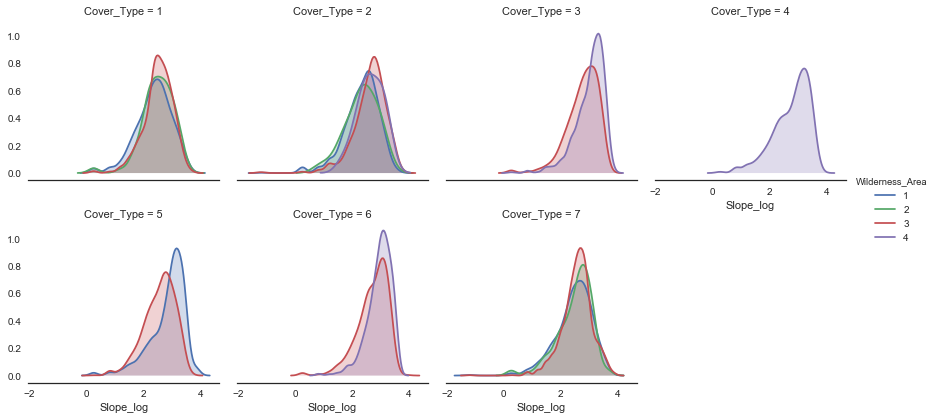

In [25]:
g = sns.FacetGrid(train_df, col="Cover_Type", hue='Wilderness_Area', size=3, col_wrap=4)
g.map(sns.kdeplot, "Slope_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [542]:
#create_dist_prob_columns(X, y, 'Slope')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

## Elevation

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


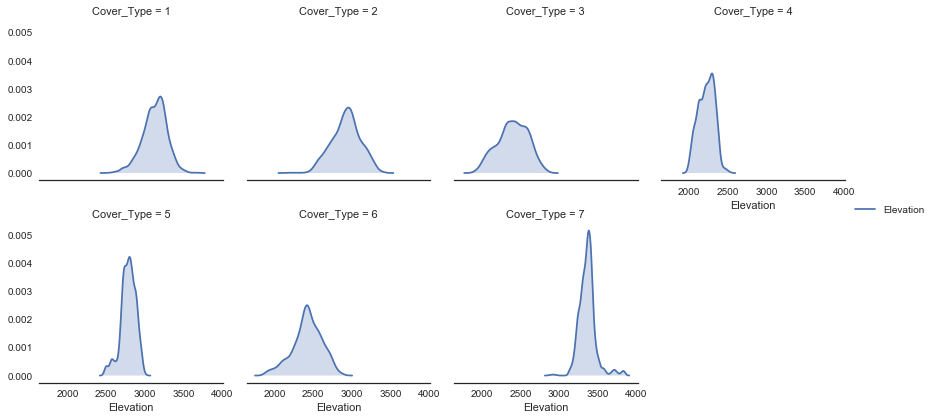

In [37]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Elevation", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


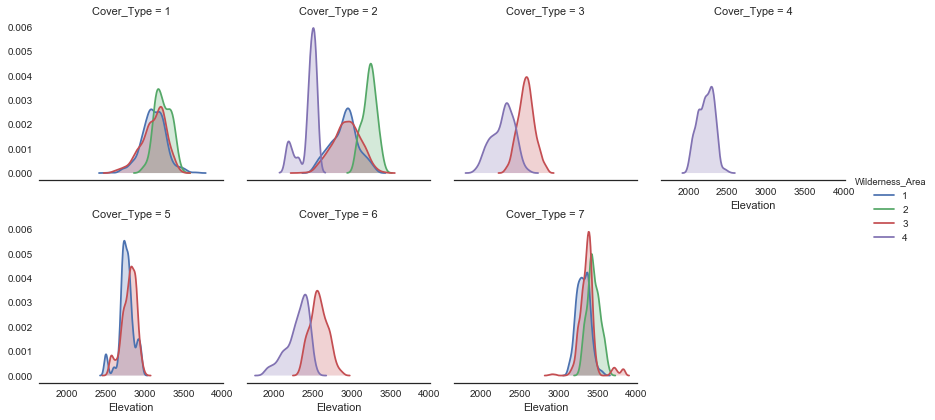

In [466]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area',col_wrap=4)
g.map(sns.kdeplot, "Elevation", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [39]:
train_df['Elevation_log'] = np.log(train_df['Elevation'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


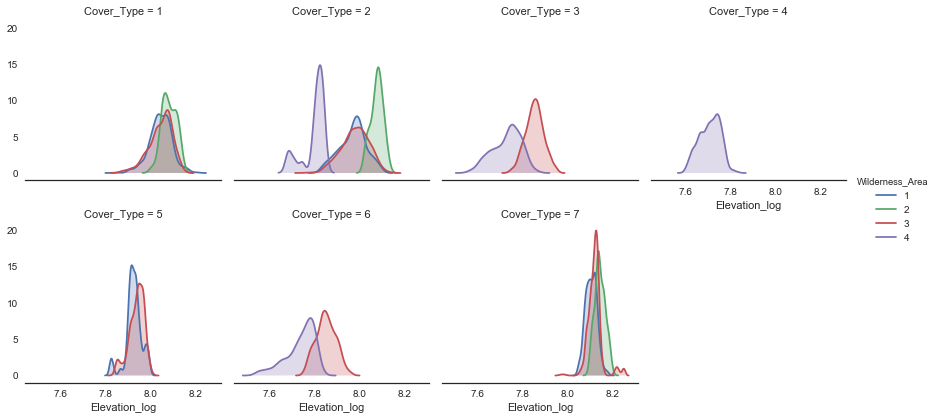

In [41]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area',col_wrap=4)
g.map(sns.kdeplot, "Elevation_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [543]:
#create_dist_prob_columns(train_df, 'Elevation')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

## Aspect

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


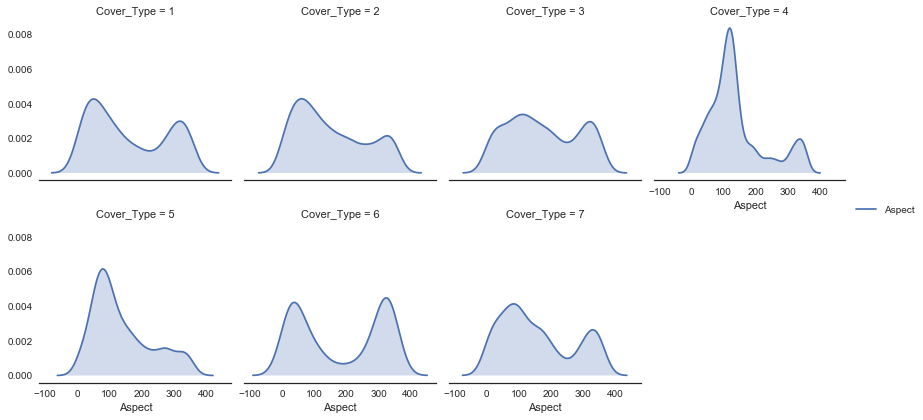

In [33]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Aspect", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


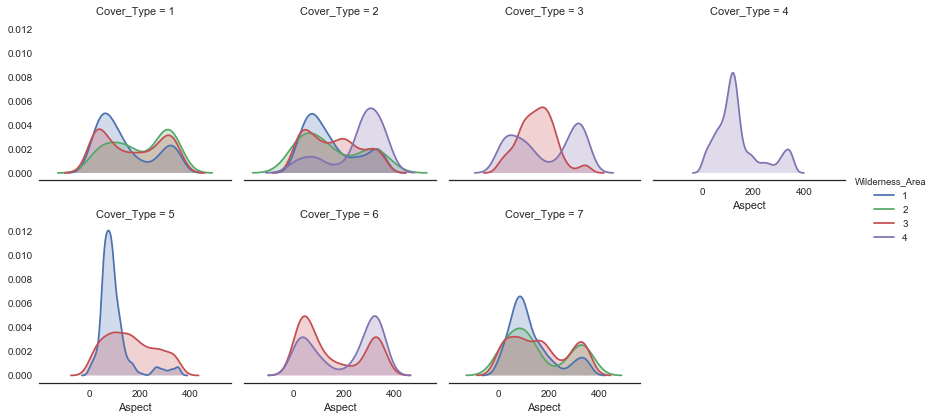

In [470]:
g = sns.FacetGrid(train_df, col="Cover_Type",hue='Wilderness_Area', size=3, col_wrap=4)
g.map(sns.kdeplot, "Aspect", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [42]:
train_df['Aspect_log'] = np.log(train_df['Aspect'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


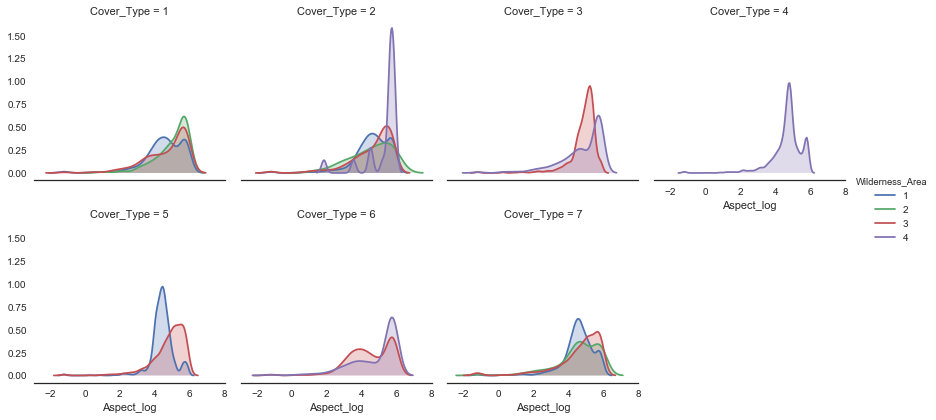

In [43]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3,hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Aspect_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [544]:
#create_dist_prob_columns(train_df, 'Aspect')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

## Horizontal_Distance_To_Hydrology

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


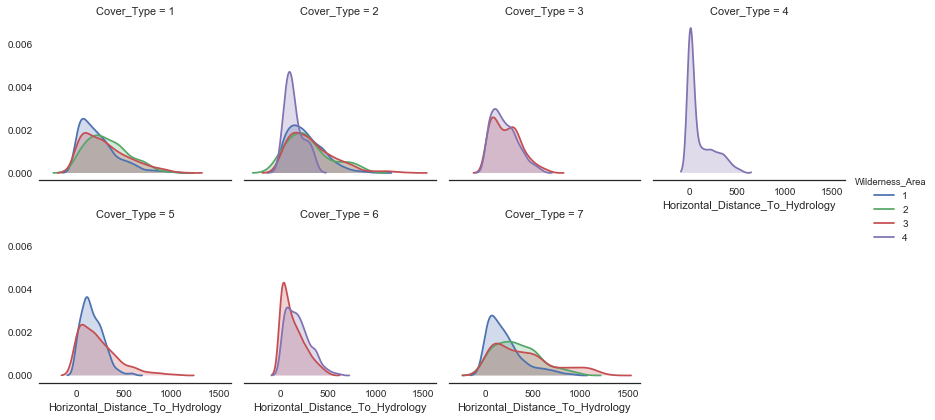

In [474]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Hydrology", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [265]:
train_df['Horizontal_Distance_To_Hydrology_log'] = np.log(train_df['Horizontal_Distance_To_Hydrology'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


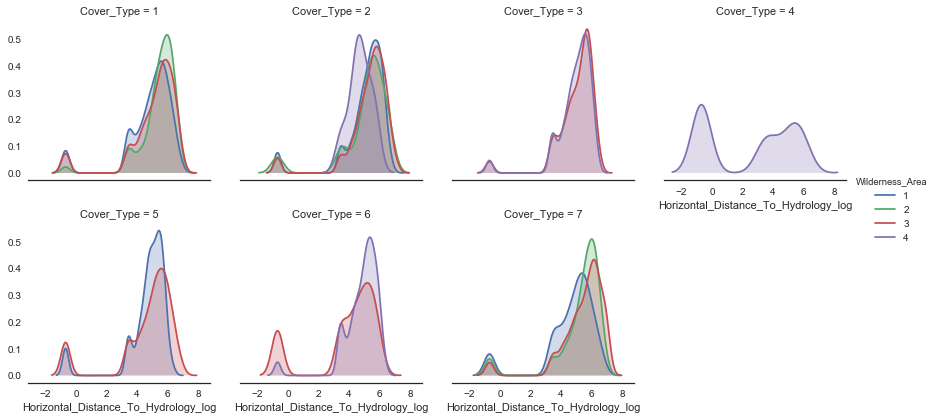

In [476]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Hydrology_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [477]:
#create_dist_prob_columns(train_df, 'Horizontal_Distance_To_Hydrology')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

# Vertical_Distance_To_Hydrology

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


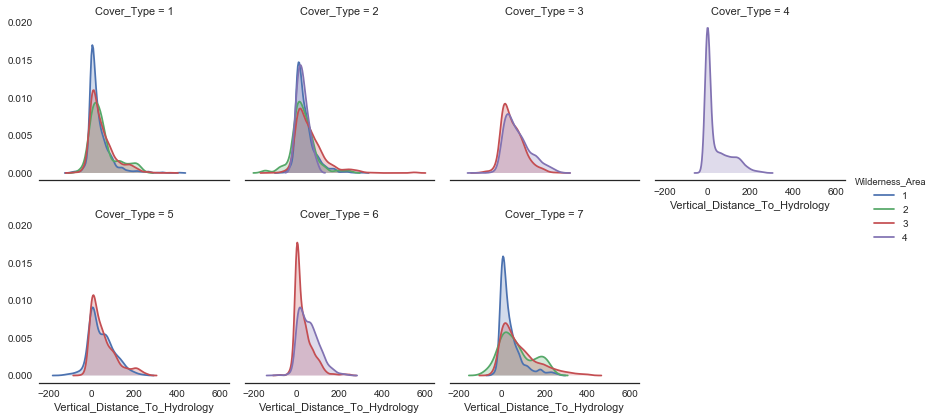

In [478]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Vertical_Distance_To_Hydrology", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [272]:
train_df['Vertical_Distance_To_Hydrology_log'] = np.log(train_df['Vertical_Distance_To_Hydrology'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


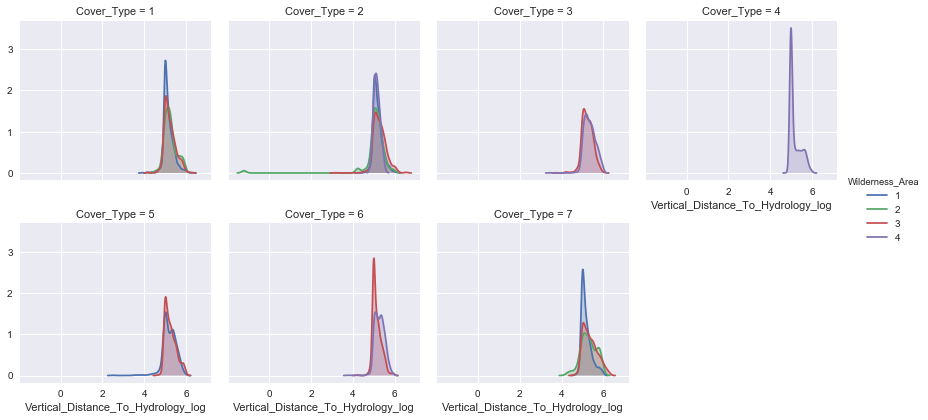

In [274]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Vertical_Distance_To_Hydrology_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [481]:
#create_dist_prob_columns(train_df, 'Vertical_Distance_To_Hydrology')

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1731: RuntimeWarn

# Horizontal_Distance_To_Roadways

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


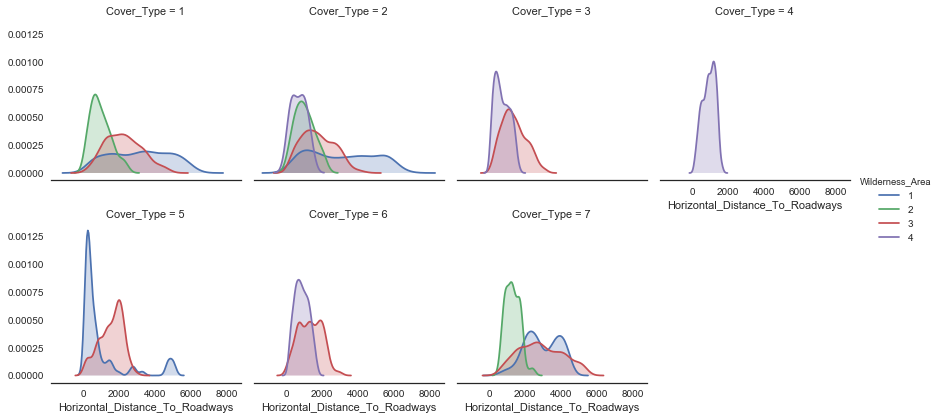

In [482]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Roadways", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [275]:
train_df['Horizontal_Distance_To_Roadways_log'] = np.log(train_df['Horizontal_Distance_To_Roadways'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


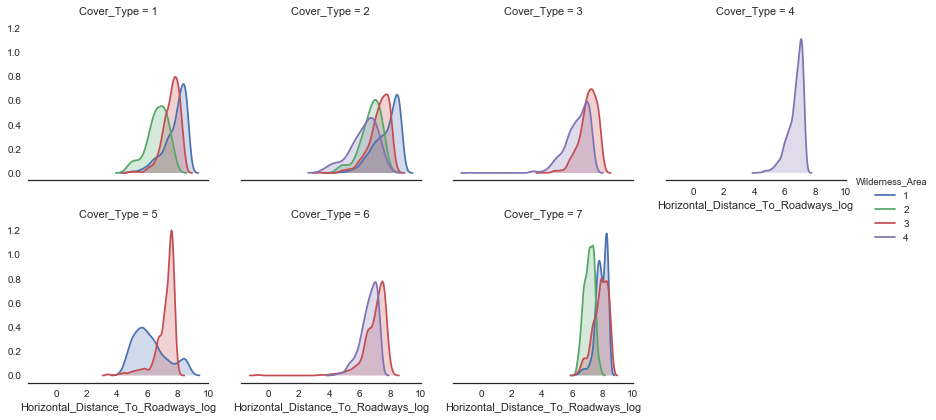

In [484]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Roadways_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [545]:
#create_dist_prob_columns(train_df, 'Horizontal_Distance_To_Roadways')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

# Horizontal_Distance_To_Fire_Points

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


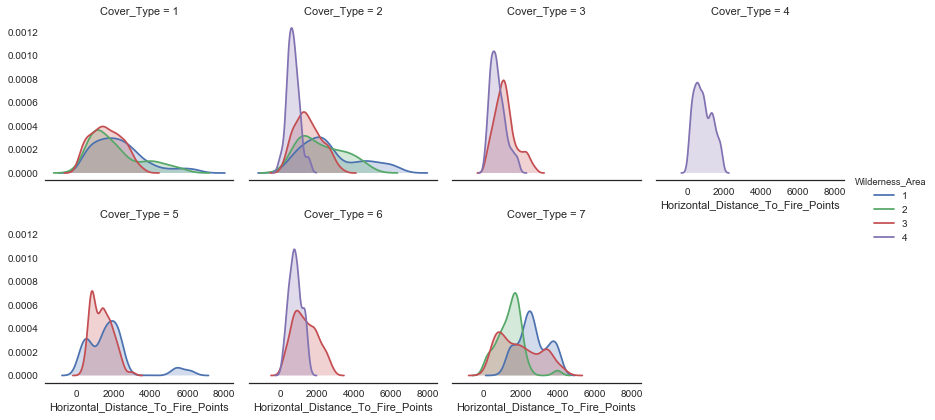

In [486]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Fire_Points", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [276]:
train_df['Horizontal_Distance_To_Fire_Points_log'] = np.log(train_df['Hillshade_9am'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


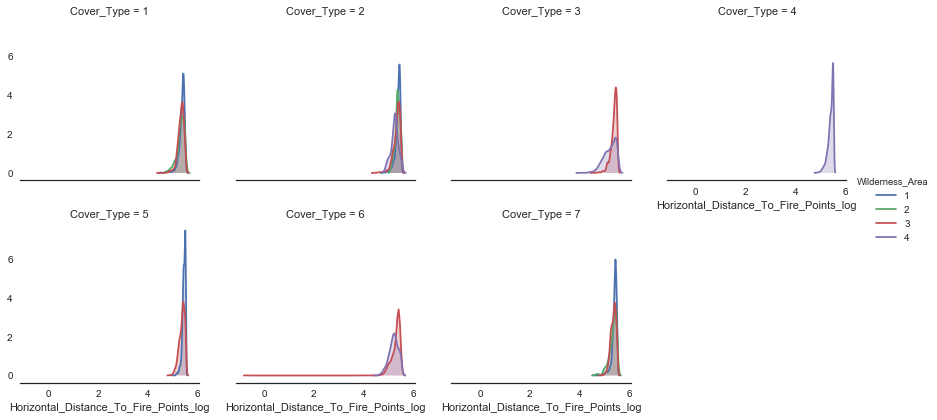

In [488]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Horizontal_Distance_To_Fire_Points_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

# Hillshade_9am

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


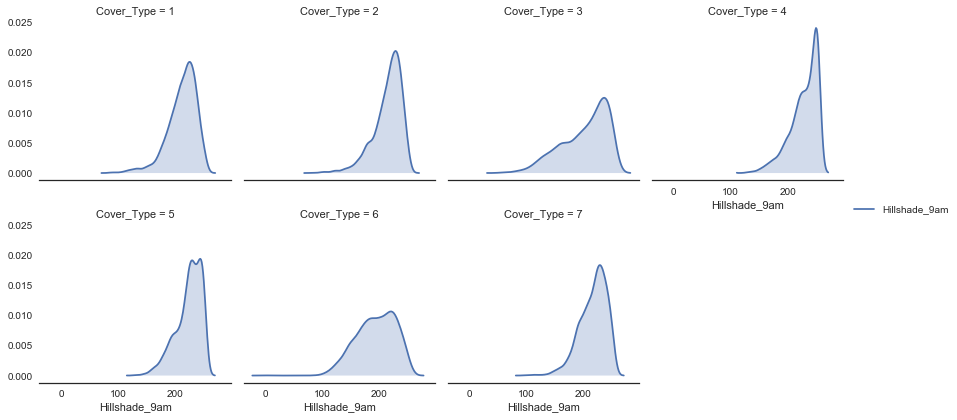

In [34]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Hillshade_9am", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


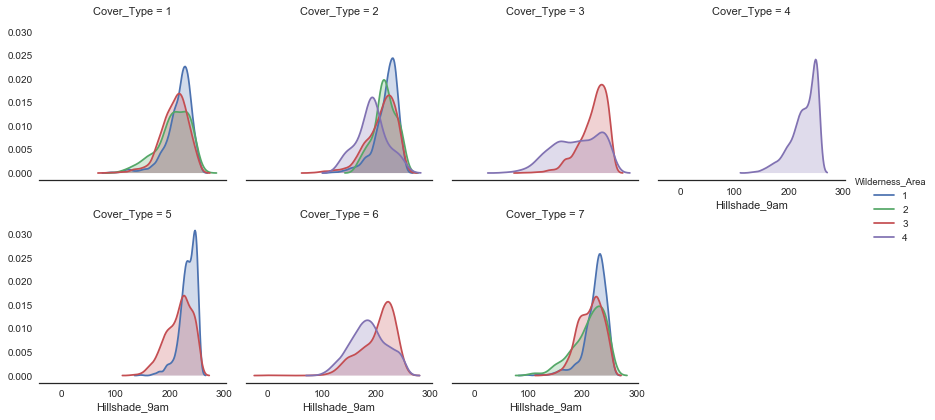

In [489]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_9am", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [277]:
train_df['Hillshade_9am_log'] = np.log(train_df['Hillshade_9am'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


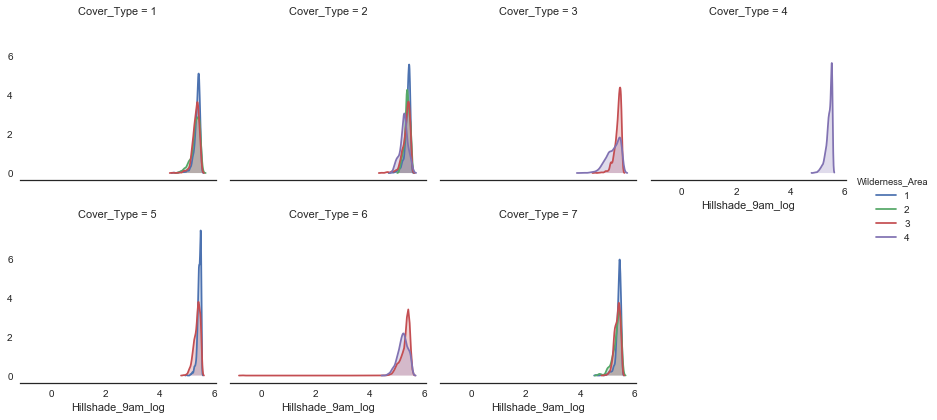

In [491]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_9am_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

# Hillshade_Noon

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


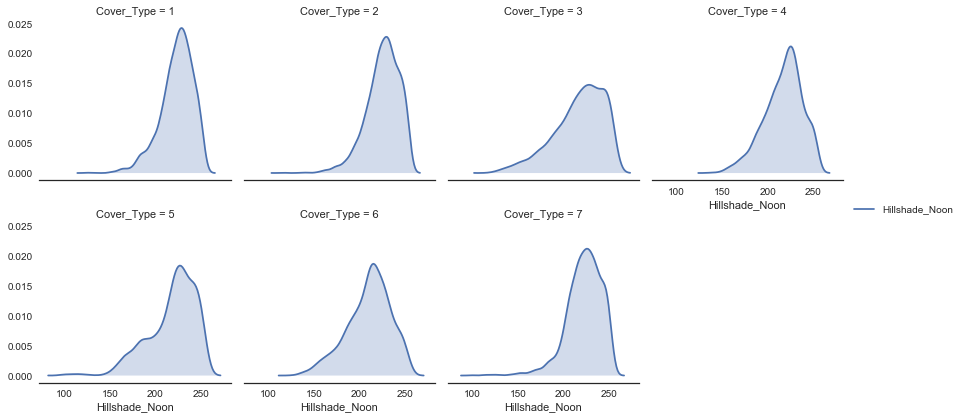

In [35]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Hillshade_Noon", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


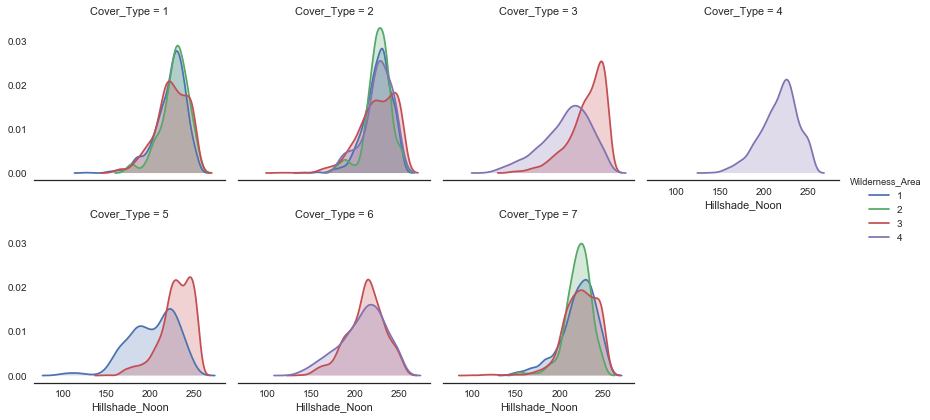

In [492]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_Noon", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [278]:
train_df['Hillshade_Noon_log'] = np.log(train_df['Hillshade_Noon'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


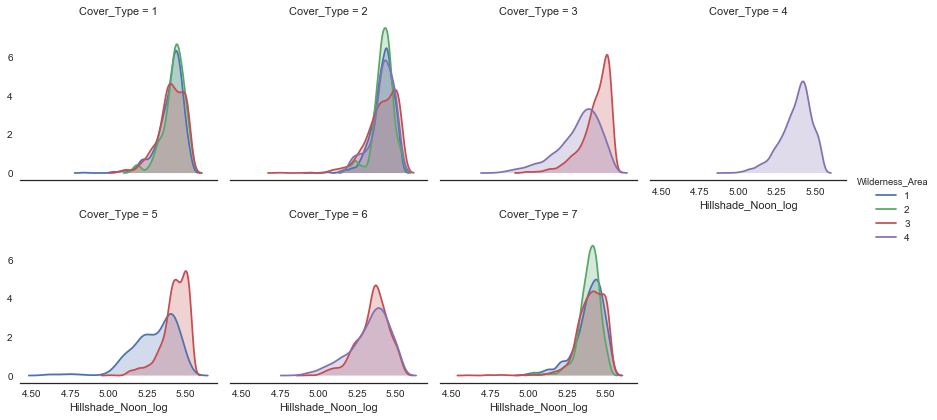

In [494]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_Noon_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [495]:
#create_dist_prob_columns(train_df, 'Hillshade_Noon')

C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1646: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1647: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1729: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\Administrator\Anaconda3\lib\site-

# Hillshade_3pm

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


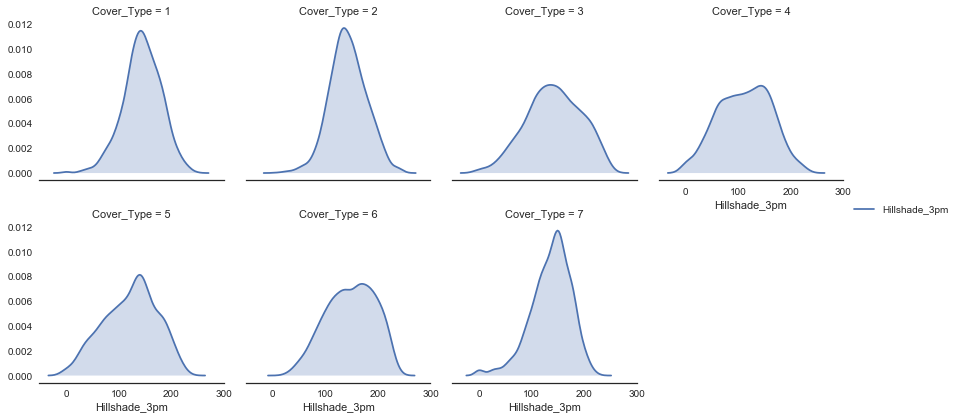

In [36]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, col_wrap=4)
g.map(sns.kdeplot, "Hillshade_3pm", shade=True).add_legend()
sns.despine(left=True)
plt.show()

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


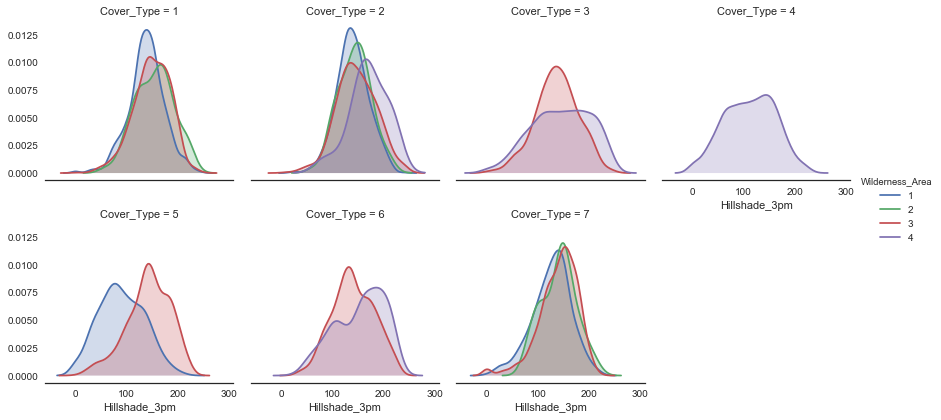

In [496]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_3pm", shade=True).add_legend()
sns.despine(left=True)
plt.show()

In [279]:
train_df['Hillshade_3pm_log'] = np.log(train_df['Hillshade_3pm'])

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


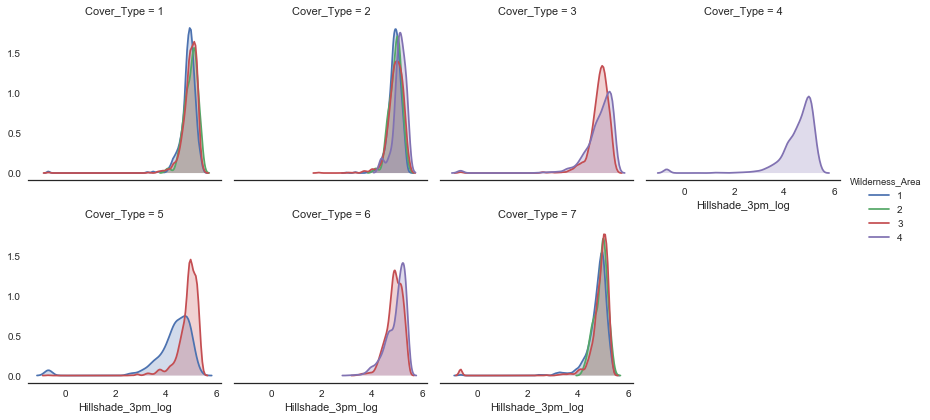

In [498]:
g = sns.FacetGrid(train_df, col="Cover_Type", size=3, hue='Wilderness_Area', col_wrap=4)
g.map(sns.kdeplot, "Hillshade_3pm_log", shade=True).add_legend()
sns.despine(left=True)
plt.show()

# Feature engineering
Focus on engineering distance continuous feature

* Elevation : unique 1665 / range [1863, 3849]
* Horizontal_Distance_To_Hydrology : unique 400 / range[0, 1343]
* Vertical_Distance_To_Hydrology : unique 423 / range[-146 ~ 554]
* Horizontal_Distance_To_Roadways : unique 3250 / range[0, 6890]
* Horizontal_Distance_To_Fire_Points : unique 2710 / range[0, 6993]

<br>

In [18]:
X = train_df.drop(['Cover_Type'], axis=1)
X['dataset'] = 0

In [19]:
X_t = test_df
X_t['dataset'] = 1

In [20]:
y_train = train_df.Cover_Type

In [21]:
def create_dist_prob_columns_(Xdf, ydf, X_, target):
    
    Xdf[target+'_log'] = np.log(Xdf[target])
    X_[target+'_log'] = np.log(X_[target])
    
    for i in ydf.unique():
        elev_cover_idx = (ydf==i)

        elev_cover_mean = Xdf[target+'_log'][elev_cover_idx].mean()
        elev_cover_std = Xdf[target+'_log'][elev_cover_idx].std()
        
        #Xdf[target+'_log_pdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        #Xdf[target+'_log_cdf_'+str(i)] = create_zero_column(Xdf.shape[0], target+'_log_pdf_'+str(i))
        
        Xdf[target+'_log_pdf_'+str(i)] = norm.pdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        Xdf[target+'_log_cdf_'+str(i)] = norm.cdf(Xdf[target+'_log'],elev_cover_mean, elev_cover_std)
        X_[target+'_log_pdf_'+str(i)] = norm.pdf(X_[target+'_log'],elev_cover_mean, elev_cover_std)
        X_[target+'_log_cdf_'+str(i)] = norm.cdf(X_[target+'_log'],elev_cover_mean, elev_cover_std)
        
        for j in Xdf['Wilderness_Area'].unique():
            
            elev_wild_cover_idx = ((ydf==i) & (X_['Wilderness_Area']==j))

            elev_wild_cover_mean = Xdf[target+'_log'][elev_wild_cover_idx].mean()
            elev_wild_cover_std = Xdf[target+'_log'][elev_wild_cover_idx].std()
            
            #Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            #Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = create_zero_column(Xdf.shape[0], target+'_log_wild_pdf_'+str(i)+str(j))
            
            Xdf[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            Xdf[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(Xdf[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            X_[target+'_log_wild_pdf_'+str(i)+str(j)] = \
                                            norm.pdf(X_[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            X_[target+'_log_wild_cdf_'+str(i)+str(j)] = \
                                            norm.cdf(X_[target+'_log'], elev_wild_cover_mean, elev_wild_cover_std)
            
            
    Xdf.fillna(0, inplace=True)
    X_.fillna(0, inplace=True)


In [27]:
X['Wilderness_Area'] = create_zero_column(X.shape[0], 'Wilderness_Area')
X_t['Wilderness_Area'] = create_zero_column(X_t.shape[0], 'Wilderness_Area')
for i in range(1, 5):
    wilderness = 'Wilderness_Area'+str(i)
    X['Wilderness_Area'][X[wilderness]==1] += i
    X_t['Wilderness_Area'][X_t[wilderness]==1] += i

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [28]:
create_dist_prob_columns_(X, y_train, X_t, 'Slope')
create_dist_prob_columns_(X, y_train, X_t, 'Elevation')
create_dist_prob_columns_(X, y_train, X_t,'Aspect')

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [31]:
X = pd.concat([X, X_t], axis=0)

In [33]:
X.shape

(581012, 270)

### Meaning of 'Aspect'
The compass direction that the slope faces is your slope aspect.
![](http://gisgeography.com/wp-content/uploads/2016/06/Aspect-Legend.png)

**북쪽으로부터**|
:---:|:---:|:---:|:---:
북|0°or 360°|남|180°
북-북동|22.5°|남-남서|202.5°
북동|45°|남서|225°
동-북동|67.5°|서-남서|247.5°
동|90°|서|270°
동-남동|112.5°|서-북서|292.5°
남동|135°|북서|315°
남-남동|157.5°|북-북서|337.5°

In [34]:
# reflecting supportive adding scalar to aspect_step
def aspect_map2(x):
    # north = 1, northeast = 2, east = 3, southeast = 4, south = 5, southwest = 6, west = 7, northwest = 8
    
    aspect_step = 22.5
    start = aspect_step/2 + 0.3
    
    if (0.3 <= x < start) or (360.3 - aspect_step/2 <= x <= 360.3): return 1;
    elif (start <= x < start+aspect_step): return 2;
    elif (start+aspect_step <= x < start+aspect_step*2): return 3;
    elif (start+aspect_step*2 <= x < start+aspect_step*3): return 4;
    elif (start+aspect_step*3 <= x < start+aspect_step*4): return 5;
    elif (start+aspect_step*4 <= x < start+aspect_step*5): return 6;
    elif (start+aspect_step*5 <= x < start+aspect_step*6): return 7;
    elif (start+aspect_step*6 <= x < start+aspect_step*7): return 8;
    elif (start+aspect_step*7 <= x < start+aspect_step*8): return 9;
    elif (start+aspect_step*8 <= x < start+aspect_step*9): return 10;
    elif (start+aspect_step*9 <= x < start+aspect_step*10): return 11;
    elif (start+aspect_step*10 <= x < start+aspect_step*11): return 12;
    elif (start+aspect_step*11 <= x < start+aspect_step*12): return 13;
    elif (start+aspect_step*12 <= x < start+aspect_step*13): return 14;
    elif (start+aspect_step*13 <= x < start+aspect_step*14): return 15;
    elif (start+aspect_step*14 <= x < start+aspect_step*15): return 16;


In [35]:
def aspect_map(x):
    # north = 1, northeast = 2, east = 3, southeast = 4, south = 5, southwest = 6, west = 7, northwest = 8
    
    if (0+0.3 <= x < 22.5+0.3) or (337.5+0.3 <= x <= 360+0.3): return 1;
    elif (22.5+0.3 <= x < 67.5+0.3): return 2;
    elif (67.5+0.3 <= x < 112.5+0.3): return 3;
    elif (112.5+0.3 <= x < 157.5+0.3): return 4;
    elif (157.5+0.3 <= x < 202.5+0.3): return 5;
    elif (202.5+0.3 <= x < 247.5+0.3): return 6;
    elif (247.5+0.3 <= x < 292.5+0.3): return 7;
    else: return 8;

In [36]:
X['Slope_Direction'] = X['Aspect'].apply(aspect_map)

In [37]:
# slope direction into dummies
X = pd.concat([X, pd.get_dummies(X.Slope_Direction, prefix='Slope_Direction')], axis=1)

In [38]:
X['Slope_Direction2'] = X['Aspect'].apply(aspect_map2)

In [39]:
# slope direction into dummies
X = pd.concat([X, pd.get_dummies(X.Slope_Direction2, prefix='Slope_Direction2')], axis=1)

In [40]:
len(X.columns)

296

# Feature Boundary by Cover Type
* Elevation
  * Elevation_Cover{1-7}
* Slope
  * Slope_Cover{1-7}
* Asepct
  * Aspect_Cover{1-7}
* Hillshade_9am
  * Hillshade_9am_Cover{1-7}
* Hillshade_Noon
  * Hillshade_Noon_Cover{1-7}
* Hillshade_3pm
  * Hillshade_3pm_Cover{1-7}

CoverType|SoilTypes|len(SoilTypes)
:---:|:---:|:---:
1|4, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 33, 35, 38, 39, 40|25
2|2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40|33
3|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 32|13
4|1, 2, 3, 4, 5, 6, 10, 11, 14, 16, 17|11
5|2, 4, 10, 11, 13, 16, 17, 18, 19, 20, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34|20
6|1, 2, 3, 4, 5, 6, 10, 11, 13, 14, 16, 17, 20, 23, 24, 31, 32, 33, 34|19
7|4, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40|18

In [41]:
X['Soil_Type'] = create_zero_column(X.shape[0], 'Soil_Type')
for i in range(1, 41):
    wilderness = 'Soil_Type'+str(i)
    X['Soil_Type'][X[wilderness]==1] += i

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [42]:
for i in range(1, 8):
    X['Soils_Cover'+str(i)] = np.zeros(X.shape[0])

In [43]:
for i, soils in enumerate(soils_by_covertypes):
    
    for j, soil in enumerate(soils):
    
        X['Soils_Cover'+str(i+1)][X['Soil_Type'] == soil] = 1
        

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [44]:
for i in range(1, 8):
    X['Elevation_Cover'+str(i)] = np.zeros(X.shape[0])

In [45]:
X['Elevation_Cover1'][(X.Elevation >= 2525) & (X.Elevation <= 3675)] = 1
X['Elevation_Cover2'][(X.Elevation >= 2169) & (X.Elevation <= 3413)] = 1
X['Elevation_Cover3'][(X.Elevation >= 1903) & (X.Elevation <= 2850)] = 1
X['Elevation_Cover4'][(X.Elevation >= 1989) & (X.Elevation <= 2526)] = 1
X['Elevation_Cover5'][(X.Elevation >= 2482) & (X.Elevation <= 3007)] = 1
X['Elevation_Cover6'][(X.Elevation >= 1863) & (X.Elevation <= 2883)] = 1
X['Elevation_Cover7'][(X.Elevation >= 2870) & (X.Elevation <= 3849)] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-p

In [46]:
for i in range(1, 8):
    X['Slope_Cover'+str(i)] = np.zeros(X.shape[0])

X['Slope_Cover1'][(X.Slope >= 1) & (X.Slope <= 41)] = 1
X['Slope_Cover2'][(X.Slope >= 0) & (X.Slope <= 45)] = 1
X['Slope_Cover3'][(X.Slope >= 1) & (X.Slope <= 47)] = 1
X['Slope_Cover4'][(X.Slope >= 1) & (X.Slope <= 46)] = 1
X['Slope_Cover5'][(X.Slope >= 1) & (X.Slope <= 50)] = 1
X['Slope_Cover6'][(X.Slope >= 1) & (X.Slope <= 52)] = 1
X['Slope_Cover7'][(X.Slope >= 0) & (X.Slope <= 49)] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [47]:
for i in range(1, 8):
    X['Hillshade_9am_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_9am_Cover1'][(X.Hillshade_9am >= 86) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover2'][(X.Hillshade_9am >= 83) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover3'][(X.Hillshade_9am >= 58) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover4'][(X.Hillshade_9am >= 127) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover5'][(X.Hillshade_9am >= 130) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover6'][(X.Hillshade_9am >= 0) & (X.Hillshade_9am <= 254)] = 1
X['Hillshade_9am_Cover7'][(X.Hillshade_9am >= 97) & (X.Hillshade_9am <= 254)] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [48]:
for i in range(1, 8):
    X['Hillshade_Noon_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_Noon_Cover1'][(X.Hillshade_Noon >= 125) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover2'][(X.Hillshade_Noon >= 115) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover3'][(X.Hillshade_Noon >= 120) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover4'][(X.Hillshade_Noon >= 137) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover5'][(X.Hillshade_Noon >= 99) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover6'][(X.Hillshade_Noon >= 127) & (X.Hillshade_Noon <= 254)] = 1
X['Hillshade_Noon_Cover7'][(X.Hillshade_Noon >= 99) & (X.Hillshade_Noon <= 254)] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [49]:
for i in range(1, 8):
    X['Hillshade_3pm_Cover'+str(i)] = np.zeros(X.shape[0])

X['Hillshade_3pm_Cover1'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 246)] = 1
X['Hillshade_3pm_Cover2'][(X.Hillshade_3pm >= 6) & (X.Hillshade_3pm <= 248)] = 1
X['Hillshade_3pm_Cover3'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 248)] = 1
X['Hillshade_3pm_Cover4'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 230)] = 1
X['Hillshade_3pm_Cover5'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 229)] = 1
X['Hillshade_3pm_Cover6'][(X.Hillshade_3pm >= 22) & (X.Hillshade_3pm <= 238)] = 1
X['Hillshade_3pm_Cover7'][(X.Hillshade_3pm >= 0) & (X.Hillshade_3pm <= 226)] = 1

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set 

In [50]:
X['Elevation_SQRD'] = X['Elevation']**2
X['Elevation_CUBE'] = X['Elevation']**3
X['Slope_SQRD'] = X['Slope']**2
X['Slope_CUBE'] = X['Slope']**3
X['Aspect_SQRD'] = X['Aspect']**2
X['Aspect_CUBE'] = X['Aspect']**3

In [159]:
con_cols

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

In [51]:
X['Horizontal_Distance_To_Hydrology_SQRD'] = \
                    X['Horizontal_Distance_To_Hydrology']**2
X['Horizontal_Distance_To_Hydrology_CUBE'] = \
                    X['Horizontal_Distance_To_Hydrology']**3
X['Horizontal_Distance_To_Roadways_SQRD'] = \
                    X['Horizontal_Distance_To_Roadways']**2
X['Horizontal_Distance_To_Roadways_CUBE'] = \
                    X['Horizontal_Distance_To_Roadways']**3
X['Horizontal_Distance_To_Fire_Points_SQRD'] =\
                    X['Horizontal_Distance_To_Fire_Points']**2
X['Horizontal_Distance_To_Fire_Points_CUBE'] =\
                    X['Horizontal_Distance_To_Fire_Points']**3
X['Vertical_Distance_To_Hydrology_SQRD'] = \
                    X['Vertical_Distance_To_Hydrology']**2
X['Vertical_Distance_To_Hydrology_CUBE'] = \
                    X['Vertical_Distance_To_Hydrology']**3

In [52]:
X['Diagnoal_Distance_To_Hydrology'] = round((X['Vertical_Distance_To_Hydrology']**2+\
                                             X['Horizontal_Distance_To_Hydrology']**2)\
                                            **(1/2), 0)

In [53]:
X['Vertical_Distance_Sum_EH'] = X.Elevation + X.Vertical_Distance_To_Hydrology

In [54]:
X['Vertical_Distance_Sum_EH_SQRD'] = (X.Elevation + X.Vertical_Distance_To_Hydrology)**2
X['Vertical_Distance_Sum_EH_CUBE'] = (X.Elevation + X.Vertical_Distance_To_Hydrology)**3

In [55]:
X['Vertical_Distance_Diff_EH'] = X.Elevation - X.Vertical_Distance_To_Hydrology
X['Vertical_Distance_Diff_EH_SQRD'] = (X.Elevation - X.Vertical_Distance_To_Hydrology)**2
X['Vertical_Distance_Diff_EH_CUBE'] = (X.Elevation - X.Vertical_Distance_To_Hydrology)**3

In [56]:
X['Vertical_Distance_Div_EH'] = round(X.Vertical_Distance_To_Hydrology / X.Elevation, 3)

In [57]:
X['Vertical_Distance_Div_EH_SQRD'] = X['Vertical_Distance_Div_EH']**2
X['Vertical_Distance_Div_EH_CUBE'] = X['Vertical_Distance_Div_EH']**3

In [58]:
X['Vertical_Distance_Mult_EH'] = X.Elevation * X.Vertical_Distance_To_Hydrology
X['Vertical_Distance_Mult_EH_SQRD'] = (X.Elevation * X.Vertical_Distance_To_Hydrology)**2
X['Vertical_Distance_Mult_EH_CUBE'] = (X.Elevation * X.Vertical_Distance_To_Hydrology)**3

In [59]:
X['Binary_Distance_To_Hydrology'] = X['Vertical_Distance_To_Hydrology'].apply(lambda x: 0 if x < 0 else 1)

In [60]:
X['Horizontal_Distance_Sum_HRF'] = X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points
X['Horizontal_Distance_Sum_HR'] = X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways
X['Horizontal_Distance_Sum_HF'] = X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Fire_Points
X['Horizontal_Distance_Sum_RF'] = X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points

In [61]:
X['Horizontal_Distance_Sum_HRF_SQRD'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points)**2
X['Horizontal_Distance_Sum_HR_SQRD'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways)**2
X['Horizontal_Distance_Sum_HF_SQRD'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Fire_Points)**2
X['Horizontal_Distance_Sum_RF_SQRD'] = (X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points)**2

In [62]:
X['Horizontal_Distance_Sum_HRF_CUBE'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points)**3
X['Horizontal_Distance_Sum_HR_CUBE'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Roadways)**3
X['Horizontal_Distance_Sum_HF_CUBE'] = (X.Horizontal_Distance_To_Hydrology + X.Horizontal_Distance_To_Fire_Points)**3
X['Horizontal_Distance_Sum_RF_CUBE'] = (X.Horizontal_Distance_To_Roadways + X.Horizontal_Distance_To_Fire_Points)**3

In [63]:
X['Horizontal_Distance_Diff_HRF'] = X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points
X['Horizontal_Distance_Diff_HR'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways)
X['Horizontal_Distance_Diff_HF'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Fire_Points)
X['Horizontal_Distance_Diff_RF'] = (X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points)

In [64]:
X['Horizontal_Distance_Diff_HRF_SQRD'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points)**2
X['Horizontal_Distance_Diff_HR_SQRD'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways)**2
X['Horizontal_Distance_Diff_HF_SQRD'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Fire_Points)**2
X['Horizontal_Distance_Diff_RF_SQRD'] = (X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points)**2

In [65]:
X['Horizontal_Distance_Diff_HRF_CUBE'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points)**3
X['Horizontal_Distance_Diff_HR_CUBE'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Roadways)**3
X['Horizontal_Distance_Diff_HF_CUBE'] = (X.Horizontal_Distance_To_Hydrology - X.Horizontal_Distance_To_Fire_Points)**3
X['Horizontal_Distance_Diff_RF_CUBE'] = (X.Horizontal_Distance_To_Roadways - X.Horizontal_Distance_To_Fire_Points)**3

In [66]:
X['Horizontal_Distance_Mult_HRF'] = X.Horizontal_Distance_To_Hydrology * X.Horizontal_Distance_To_Roadways * X.Horizontal_Distance_To_Fire_Points
X['Horizontal_Distance_Mult_HR'] = X.Horizontal_Distance_To_Hydrology * X.Horizontal_Distance_To_Roadways
X['Horizontal_Distance_Mult_HF'] = X.Horizontal_Distance_To_Hydrology * X.Horizontal_Distance_To_Fire_Points
X['Horizontal_Distance_Mult_RF'] = X.Horizontal_Distance_To_Roadways * X.Horizontal_Distance_To_Fire_Points

In [67]:
print(len(X[X['Hillshade_9am']==0]), len(X[X['Hillshade_Noon']==0]), len(X[X['Hillshade_3pm']==0]))

0 0 0


In [68]:
X['Hillshade_9am_SQRD'] = X['Hillshade_9am']**2
X['Hillshade_9am_CUBE'] = X['Hillshade_9am']**3
X['Hillshade_Noon_SQRD'] = X['Hillshade_Noon']**2
X['Hillshade_Noon_CUBE'] = X['Hillshade_Noon']**3
X['Hillshade_3pm_SQRD'] = X['Hillshade_3pm']**2
X['Hillshade_3pm_CUBE'] = X['Hillshade_3pm']**3

In [69]:
X['Hillshade_Sum'] = X['Hillshade_3pm'] + X['Hillshade_9am'] + X['Hillshade_Noon']
X['Hillshade_Sum_SQRD'] = (X['Hillshade_3pm'] + X['Hillshade_9am'] + X['Hillshade_Noon'])**2
X['Hillshade_Sum_CUBE'] = (X['Hillshade_3pm'] + X['Hillshade_9am'] + X['Hillshade_Noon'])**3

In [70]:
X['Hillshade_Sum_0912'] = X['Hillshade_Noon'] + X['Hillshade_9am']
X['Hillshade_Sum_0912_SQRD'] = (X['Hillshade_Noon'] + X['Hillshade_9am'])**2
X['Hillshade_Sum_0912_CUBE'] = (X['Hillshade_Noon'] + X['Hillshade_9am'])**3

X['Hillshade_Sum_1215'] = X['Hillshade_3pm'] + X['Hillshade_Noon']
X['Hillshade_Sum_1215_SQRD'] = (X['Hillshade_3pm'] + X['Hillshade_Noon'])**2
X['Hillshade_Sum_1215_CUBE'] = (X['Hillshade_3pm'] + X['Hillshade_Noon'])**3

X['Hillshade_Sum_0915'] = X['Hillshade_3pm'] + X['Hillshade_9am']
X['Hillshade_Sum_0915_SQRD'] = (X['Hillshade_3pm'] + X['Hillshade_9am'])**2
X['Hillshade_Sum_0915_CUBE'] = (X['Hillshade_3pm'] + X['Hillshade_9am'])**3


In [71]:
X['Hillshade_Diff'] = X['Hillshade_3pm'] - X['Hillshade_9am'] - X['Hillshade_Noon']
X['Hillshade_Diff_SQRD'] = (X['Hillshade_3pm'] - X['Hillshade_9am'] - X['Hillshade_Noon'])**2
X['Hillshade_Diff_CUBE'] = (X['Hillshade_3pm'] - X['Hillshade_9am'] - X['Hillshade_Noon'])**3

In [72]:
X['Hillshade_Diff_0912'] = X['Hillshade_Noon'] - X['Hillshade_9am']
X['Hillshade_Diff_0912_SQRD'] = (X['Hillshade_Noon'] - X['Hillshade_9am'])**2
X['Hillshade_Diff_0912_CUBE'] = (X['Hillshade_Noon'] - X['Hillshade_9am'])**3

X['Hillshade_Diff_1215'] = X['Hillshade_3pm'] - X['Hillshade_Noon']
X['Hillshade_Diff_1215_SQRD'] = (X['Hillshade_3pm'] - X['Hillshade_Noon'])**2
X['Hillshade_Diff_1215_CUBE'] = (X['Hillshade_3pm'] - X['Hillshade_Noon'])**3

X['Hillshade_Diff_0915'] = X['Hillshade_3pm'] - X['Hillshade_9am']
X['Hillshade_Diff_0915_SQRD'] = (X['Hillshade_3pm'] - X['Hillshade_9am'])**2
X['Hillshade_Diff_0915_CUBE'] = (X['Hillshade_3pm'] - X['Hillshade_9am'])**3

In [73]:
X['Hillshade_Mult_091215'] = X['Hillshade_3pm'] * X['Hillshade_Noon'] * X['Hillshade_9am']
X['Hillshade_Mult_0912'] = X['Hillshade_Noon'] * X['Hillshade_9am']
X['Hillshade_Mult_1215'] = X['Hillshade_3pm'] * X['Hillshade_Noon']
X['Hillshade_Mult_0915'] = X['Hillshade_3pm'] * X['Hillshade_9am']

In [74]:
X['Hillshade_ratio_091215'] = X['Hillshade_3pm'] / X['Hillshade_Noon'] / X['Hillshade_9am']
X['Hillshade_ratio_0912'] = X['Hillshade_Noon'] / X['Hillshade_9am']
X['Hillshade_ratio_1215'] = X['Hillshade_3pm'] / X['Hillshade_Noon']
X['Hillshade_ratio_0915'] = X['Hillshade_3pm'] / X['Hillshade_9am']

In [75]:
import math

In [76]:
X['Radians_To_Hydrology'] = list(map(math.atan2,X['Vertical_Distance_To_Hydrology'],\
                                     X['Horizontal_Distance_To_Hydrology']))

In [77]:
X['Radians_To_Hydrology'] = round(X['Radians_To_Hydrology'], 2)
X['Radians_To_Hydrology_SQRD'] = X['Radians_To_Hydrology']**2
X['Radians_To_Hydrology_CUBE'] = X['Radians_To_Hydrology']**3

In [78]:
X_train = X[X.dataset==0].drop(['Id','dataset'], axis=1); #X_train.to_csv('X_train_notscaled.csv', sep=',')
X_test = X[X.dataset==1].drop(['Id', 'dataset'], axis=1); #X_test.to_csv('X_test_notscaled.csv', sep=',')

In [74]:
print(len(X.columns))

233


In [331]:
X.head(10)

,Aspect,Aspect_log,Elevation,Elevation_log,Hillshade_3pm,Hillshade_3pm_log,Hillshade_9am,Hillshade_9am_log,Hillshade_Noon,Hillshade_Noon_log,...,Hillshade_Mult_0912,Hillshade_Mult_1215,Hillshade_Mult_0915,Hillshade_ratio_091215,Hillshade_ratio_0912,Hillshade_ratio_1215,Hillshade_ratio_0915,Radians_To_Hydrology,Radians_To_Hydrology_SQRD,Radians_To_Hydrology_CUBE
0,51.3,3.937691,2596.3,7.861843,148.3,4.999237,221.3,5.399519,232.3,5.448030,...,51407.99,34450.09,32818.79,0.002885,1.049706,0.638399,0.670131,0.00,0.0000,0.000000
1,56.3,4.030695,2590.3,7.859529,151.3,5.019265,220.3,5.394990,235.3,5.460861,...,51836.59,35600.89,33331.39,0.002919,1.068089,0.643009,0.686791,-0.03,0.0009,-0.000027
2,139.3,4.936630,2804.3,7.938909,135.3,4.907495,234.3,5.456602,238.3,5.473530,...,55833.69,32241.99,31700.79,0.002423,1.017072,0.567772,0.577465,0.24,0.0576,0.013824
3,155.3,5.045359,2785.3,7.932111,122.3,4.806477,238.3,5.473530,238.3,5.473530,...,56786.89,29144.09,29144.09,0.002154,1.000000,0.513219,0.513219,0.45,0.2025,0.091125
4,45.3,3.813307,2595.3,7.861457,150.3,5.012633,220.3,5.394990,234.3,5.456602,...,51616.29,35215.29,33111.09,0.002912,1.063550,0.641485,0.682251,-0.00,0.0000,-0.000000
5,132.3,4.885072,2579.3,7.855273,140.3,4.943783,230.3,5.439383,237.3,5.469325,...,54650.19,33293.19,32311.09,0.002567,1.030395,0.591235,0.609205,-0.05,0.0025,-0.000125
6,45.3,3.813307,2606.3,7.865687,138.3,4.929425,222.3,5.404028,225.3,5.417433,...,50084.19,31158.99,30744.09,0.002761,1.013495,0.613848,0.622132,0.02,0.0004,0.000008
7,49.3,3.897924,2605.3,7.865303,144.3,4.971894,222.3,5.404028,230.3,5.439383,...,51195.69,33232.29,32077.89,0.002819,1.035987,0.626574,0.649123,0.03,0.0009,0.000027
8,45.3,3.813307,2617.3,7.869899,133.3,4.892602,223.3,5.408516,221.3,5.399519,...,49416.29,29499.29,29765.89,0.002697,0.991043,0.602350,0.596955,0.23,0.0529,0.012167
9,59.3,4.082609,2612.3,7.867986,124.3,4.822698,228.3,5.430661,219.3,5.390441,...,50066.19,27258.99,28377.69,0.002483,0.960578,0.566803,0.544459,0.05,0.0025,0.000125


In [192]:
for col in X.columns:
    
    try:
        print(col, X[col].isnull().sum(), X[col][X[col].isnull()].count())
        
    except:
        pass

Aspect 0 0
Elevation 0 0
Hillshade_3pm 0 0
Hillshade_9am 0 0
Hillshade_Noon 0 0
Horizontal_Distance_To_Fire_Points 0 0
Horizontal_Distance_To_Hydrology 0 0
Horizontal_Distance_To_Roadways 0 0
Id 0 0
Slope 0 0
Soil_Type1 0 0
Soil_Type10 0 0
Soil_Type11 0 0
Soil_Type12 0 0
Soil_Type13 0 0
Soil_Type14 0 0
Soil_Type15 0 0
Soil_Type16 0 0
Soil_Type17 0 0
Soil_Type18 0 0
Soil_Type19 0 0
Soil_Type2 0 0
Soil_Type20 0 0
Soil_Type21 0 0
Soil_Type22 0 0
Soil_Type23 0 0
Soil_Type24 0 0
Soil_Type25 0 0
Soil_Type26 0 0
Soil_Type27 0 0
Soil_Type28 0 0
Soil_Type29 0 0
Soil_Type3 0 0
Soil_Type30 0 0
Soil_Type31 0 0
Soil_Type32 0 0
Soil_Type33 0 0
Soil_Type34 0 0
Soil_Type35 0 0
Soil_Type36 0 0
Soil_Type37 0 0
Soil_Type38 0 0
Soil_Type39 0 0
Soil_Type4 0 0
Soil_Type40 0 0
Soil_Type5 0 0
Soil_Type6 0 0
Soil_Type7 0 0
Soil_Type8 0 0
Soil_Type9 0 0
Vertical_Distance_To_Hydrology 0 0
Wilderness_Area 0 0
Wilderness_Area1 0 0
Wilderness_Area2 0 0
Wilderness_Area3 0 0
Wilderness_Area4 0 0
dataset 0 0
Slope_Dir

# Scaling

In [79]:
std_sc = StandardScaler()
X_scaled = std_sc.fit_transform(X_train)
X_scaled_test = std_sc.transform(X_test)

In [80]:
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns, index=range(X_train.shape[0]))
X_scaled_test = pd.DataFrame(X_scaled_test, columns=X_test.columns, index=range(X_test.shape[0]))

In [81]:
X_scaled.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Hillshade_Mult_0912,Hillshade_Mult_1215,Hillshade_Mult_0915,Hillshade_ratio_091215,Hillshade_ratio_0912,Hillshade_ratio_1215,Hillshade_ratio_0915,Radians_To_Hydrology,Radians_To_Hydrology_SQRD,Radians_To_Hydrology_CUBE
0,-0.367095,-0.959980,-1.597132,0.146639,-0.834074,-0.908681,0.271454,0.571653,0.281259,4.334805,...,0.590518,0.353266,0.690519,-0.013068,-0.009555,0.149628,-0.009923,-1.147755,-0.733580,-0.535089
1,-0.381461,-0.914559,-1.715424,-0.072337,-0.932054,-0.999246,0.238732,0.703225,0.346627,4.285710,...,0.644219,0.451934,0.760284,-0.012215,-0.005240,0.173828,-0.007268,-1.270778,-0.728789,-0.535269
2,0.130912,-0.160577,-0.887379,0.194243,0.227369,1.106379,0.696843,0.834797,-0.002005,4.191156,...,1.145035,0.163944,0.538360,-0.024644,-0.017214,-0.221096,-0.024693,-0.163577,-0.426957,-0.442890
3,0.085421,-0.015231,0.177250,0.070474,1.092853,1.038455,0.827731,0.834797,-0.285268,4.272981,...,1.264466,-0.101668,0.190394,-0.031407,-0.021220,-0.507448,-0.034933,0.697579,0.344392,0.072673
4,-0.369489,-1.014485,-1.715424,-0.353198,-0.850404,-0.998491,0.238732,0.659368,0.324838,4.237524,...,0.616617,0.418873,0.730301,-0.012388,-0.006306,0.165830,-0.007992,-1.147755,-0.733580,-0.535089


In [438]:
X_scaled_test.head()

,Aspect,Elevation,Hillshade_3pm,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Fire_Points,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Slope,Soil_Type1,...,Hillshade_Mult_0912,Hillshade_Mult_1215,Hillshade_Mult_0915,Hillshade_ratio_091215,Hillshade_ratio_0912,Hillshade_ratio_1215,Hillshade_ratio_0915,Radians_To_Hydrology,Radians_To_Hydrology_SQRD,Radians_To_Hydrology_CUBE
0,1.792510,-0.165977,0.455575,-0.546602,-0.217778,4.667563,-1.081532,0.732045,-0.295918,-0.155059,...,-0.579848,0.271384,0.399661,0.007769,0.000300,0.627044,0.010175,2.091832,2.588704,2.753255
1,-1.423270,-0.158794,0.368417,-0.382991,-0.130064,4.694838,-1.081532,0.709404,-0.414210,-0.155059,...,-0.395151,0.224005,0.396435,0.002310,-0.003732,0.494575,0.003856,2.091832,2.588704,2.753255
2,-1.277924,-0.086966,0.041574,-0.219380,-0.480922,4.393901,-1.081532,0.955438,-0.177626,-0.155059,...,-0.466432,-0.148353,0.078915,-0.005285,-0.018945,0.258529,-0.010656,2.091832,2.588704,2.753255
3,-1.205251,-0.096543,-0.219900,-0.153935,-0.787923,4.421177,-1.081532,0.932797,0.058958,-0.155059,...,-0.596926,-0.437870,-0.223907,-0.010472,-0.029107,0.065934,-0.020856,2.091832,2.588704,2.753255
4,-1.159831,-0.103726,-0.437795,-0.088491,-1.051067,4.448452,-1.081532,0.910156,0.295543,-0.155059,...,-0.704579,-0.669778,-0.476018,-0.015012,-0.037960,-0.102457,-0.029347,2.091832,2.588704,2.753255


In [82]:
X_scaled.to_csv('X_scaled.csv', sep=',')
X_scaled_test.to_csv('X_scaled_test.csv', sep=',')

# Feature Engineering, done.